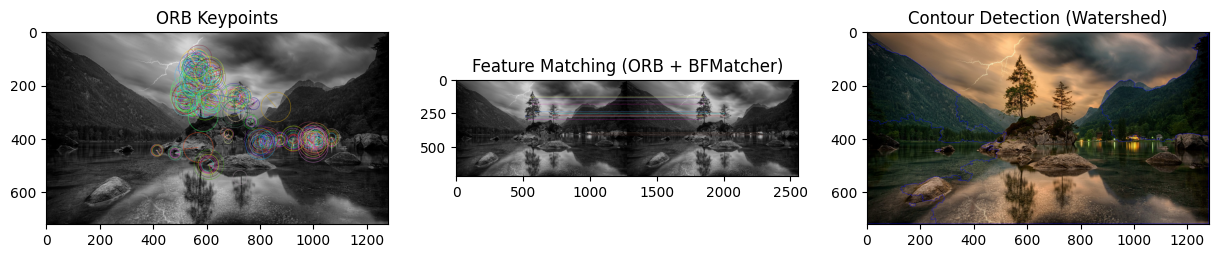

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img1 = cv2.imread("/content/nature.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("/content/nature.jpg", cv2.IMREAD_GRAYSCALE)
color_img = cv2.imread("/content/nature.jpg")

orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

orb_img = cv2.drawKeypoints(img1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key=lambda x: x.distance)

feature_match_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

sure_bg = cv2.dilate(opening, kernel, iterations=3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

cv2.watershed(color_img, markers)
color_img[markers == -1] = [255, 0, 0]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(orb_img, cmap="gray")
plt.title("ORB Keypoints")

plt.subplot(1, 3, 2)
plt.imshow(feature_match_img)
plt.title("Feature Matching (ORB + BFMatcher)")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))
plt.title("Contour Detection (Watershed)")

plt.show()


# ***RESNET 34***

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet34, ResNet34_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet requires 224x224 input
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

In [4]:
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

100%|██████████| 169M/169M [00:05<00:00, 29.3MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)  # CIFAR-100 has 100 classes
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 154MB/s]


In [6]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

In [7]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [9]:
num_epochs = 5
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=running_loss / len(train_loader))

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/5: 100%|██████████| 782/782 [01:59<00:00,  6.57it/s, loss=1.32]


Epoch [1/5], Loss: 1.3193, Accuracy: 0.6297


Epoch 2/5: 100%|██████████| 782/782 [01:57<00:00,  6.63it/s, loss=1.29]


Epoch [2/5], Loss: 1.2877, Accuracy: 0.6352


Epoch 3/5: 100%|██████████| 782/782 [01:58<00:00,  6.61it/s, loss=1.27]


Epoch [3/5], Loss: 1.2681, Accuracy: 0.6411


Epoch 4/5: 100%|██████████| 782/782 [01:57<00:00,  6.64it/s, loss=1.25]


Epoch [4/5], Loss: 1.2510, Accuracy: 0.6439


Epoch 5/5: 100%|██████████| 782/782 [01:58<00:00,  6.57it/s, loss=1.23]

Epoch [5/5], Loss: 1.2295, Accuracy: 0.6515


In [10]:
model.eval()
all_preds, all_labels, all_probs = [], [], []
correct, total = 0, 0

progress_bar = tqdm(test_loader, desc="Evaluating")

with torch.no_grad():
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Compute class probabilities
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total

Evaluating: 100%|██████████| 157/157 [00:23<00:00,  6.71it/s]


In [11]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.6100
Precision: 0.6309
Recall: 0.6100
F1-Score: 0.6061


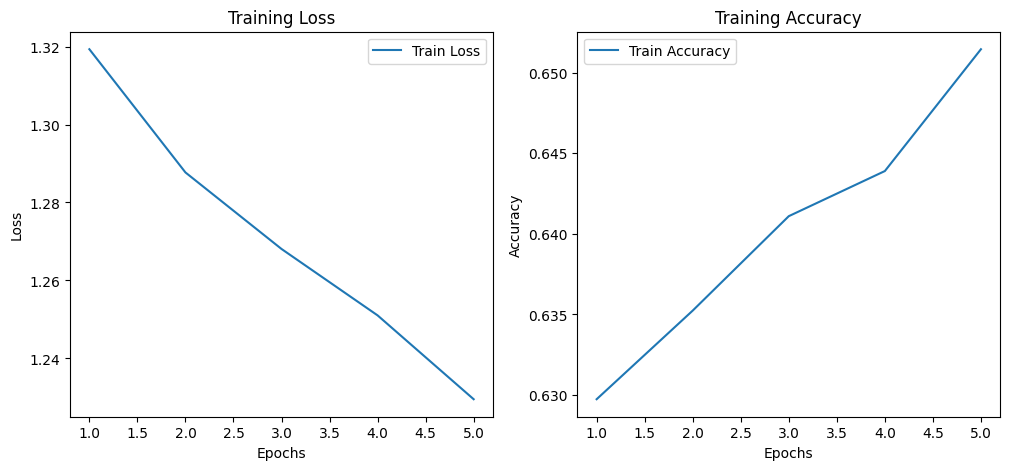

In [12]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.show()

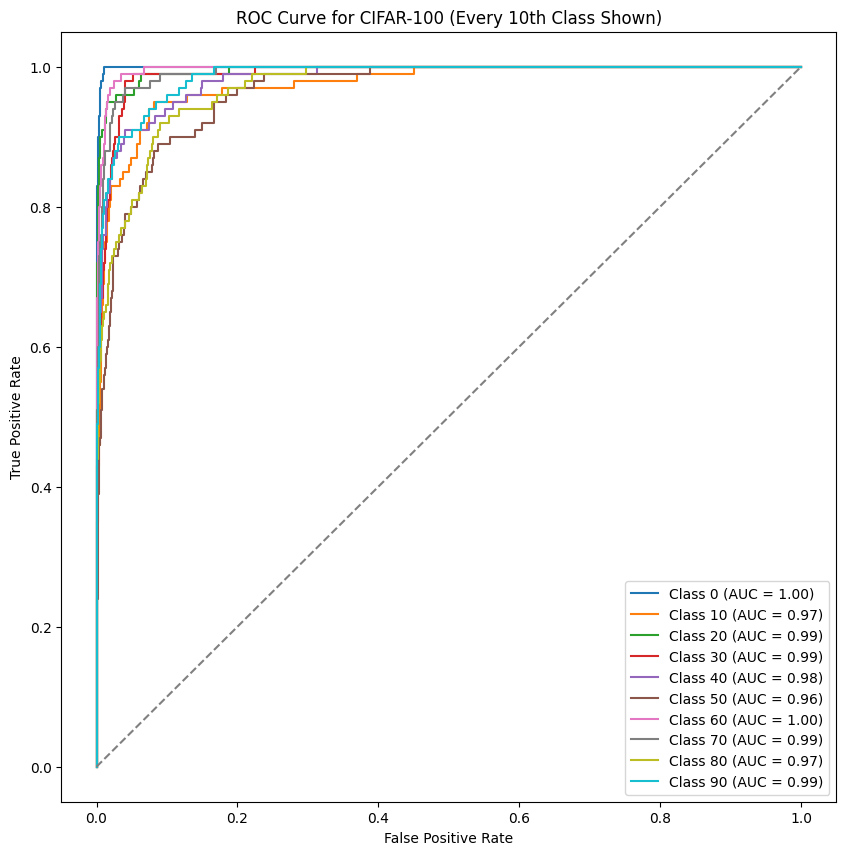

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Number of classes (CIFAR-100)
num_classes = 100

# Convert labels to one-hot encoding
all_labels_one_hot = np.eye(num_classes)[all_labels]
all_probs = np.array(all_probs)  # Ensure predictions are in array format

# Plot ROC Curves for all 100 classes
plt.figure(figsize=(10, 10))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels_one_hot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot every 10th class to avoid overcrowding
    if i % 10 == 0:
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Random guess line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Plot settings
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for CIFAR-100 (Every 10th Class Shown)")
plt.legend()
plt.show()

# ***RESNET 18***

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet requires 224x224 input
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

In [16]:
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [17]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)  # CIFAR-100 has 100 classes
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 100MB/s]


In [18]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [20]:
num_epochs = 5
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=running_loss / len(train_loader))

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/5: 100%|██████████| 782/782 [01:44<00:00,  7.47it/s, loss=2.38]


Epoch [1/5], Loss: 2.3813, Accuracy: 0.4259


Epoch 2/5: 100%|██████████| 782/782 [01:41<00:00,  7.70it/s, loss=1.63]


Epoch [2/5], Loss: 1.6325, Accuracy: 0.5582


Epoch 3/5: 100%|██████████| 782/782 [01:40<00:00,  7.78it/s, loss=1.5]


Epoch [3/5], Loss: 1.4971, Accuracy: 0.5864


Epoch 4/5: 100%|██████████| 782/782 [01:41<00:00,  7.74it/s, loss=1.44]


Epoch [4/5], Loss: 1.4363, Accuracy: 0.6008


Epoch 5/5: 100%|██████████| 782/782 [01:43<00:00,  7.58it/s, loss=1.4]

Epoch [5/5], Loss: 1.4000, Accuracy: 0.6079


In [21]:
model.eval()
all_preds, all_labels, all_probs = [], [], []
correct, total = 0, 0

progress_bar = tqdm(test_loader, desc="Evaluating")

with torch.no_grad():
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Compute class probabilities
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total

Evaluating: 100%|██████████| 157/157 [00:23<00:00,  6.66it/s]


In [22]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.5830
Precision: 0.6072
Recall: 0.5830
F1-Score: 0.5780


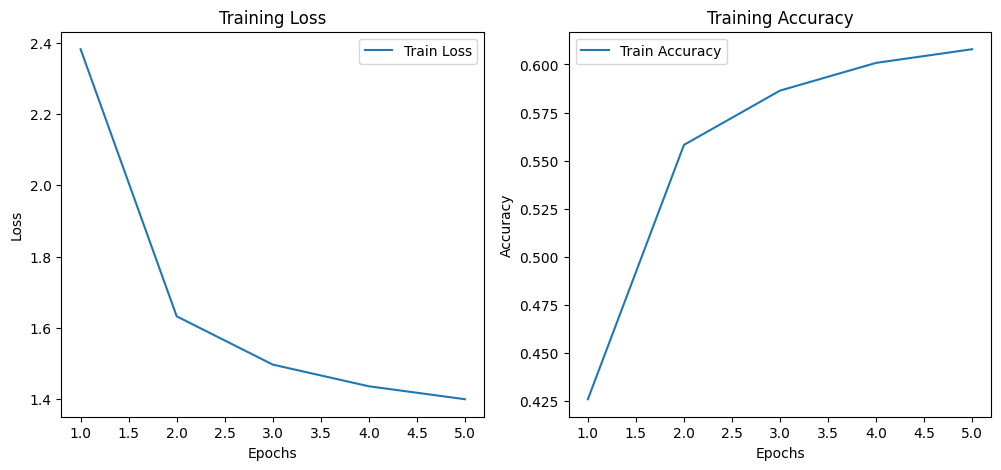

In [23]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.show()


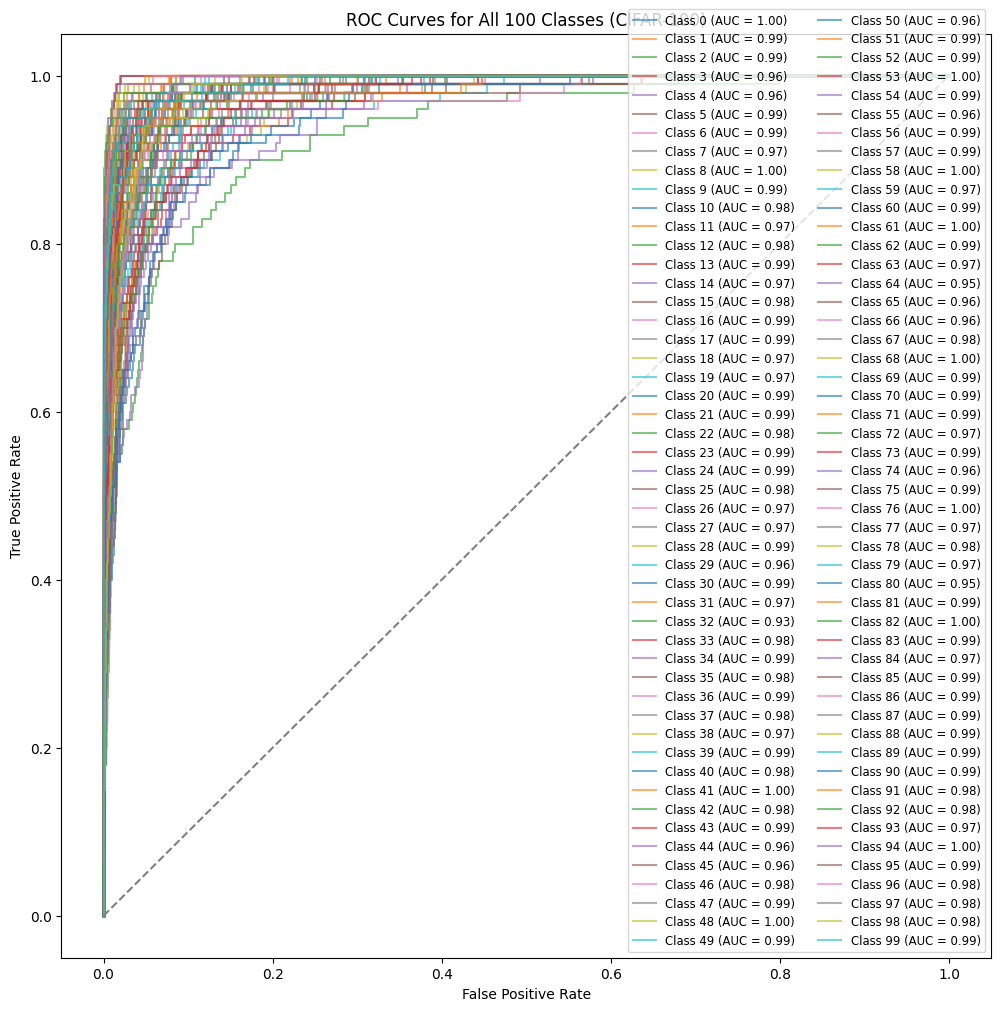

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Number of classes (CIFAR-100)
num_classes = 100

# Convert labels to one-hot encoding
all_labels_one_hot = np.eye(num_classes)[all_labels]
all_probs = np.array(all_probs)  # Ensure predictions are in array format

# Initialize the figure
plt.figure(figsize=(12, 12))

# Compute ROC for all 100 classes
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels_one_hot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve for each class
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})", alpha=0.6)

# Random guess line (y = x)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Plot settings
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All 100 Classes (CIFAR-100)")
plt.legend(fontsize="small", loc="lower right", ncol=2)
plt.show()


# ***MetaLearning Pipeline***

In [25]:
import torch
import random
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2


transform = transforms.Compose([transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)


images = mnist_data.data.float() / 255.0
labels = mnist_data.targets


alpha = 10
sigma = 3


random_state = np.random.RandomState(None)
dx = cv2.GaussianBlur((random_state.rand(28, 28) * 2 - 1), (3, 3), sigma) * alpha
dy = cv2.GaussianBlur((random_state.rand(28, 28) * 2 - 1), (3, 3), sigma) * alpha
x, y = np.meshgrid(np.arange(28), np.arange(28))
map_x = np.float32(x + dx)
map_y = np.float32(y + dy)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 337kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.78MB/s]


In [26]:
for i in range(len(images)):
    images[i] = torch.tensor(cv2.remap(images[i].numpy(), map_x, map_y, interpolation=cv2.INTER_LINEAR))


train_size = int(0.8 * len(images))
test_size = len(images) - train_size
train_images, test_images = images[:train_size], images[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

In [27]:
N = 5  # Number of classes per episode
K = 5  # Number of support samples per class
Q = 3  # Number of query samples per class


selected_classes = random.sample(range(10), N)


support_images, support_labels = [], []
query_images, query_labels = [], []


for cls in selected_classes:
    class_indices = torch.where(train_labels == cls)[0]
    selected_samples = torch.randperm(len(class_indices))

    support_indices = class_indices[selected_samples[:K]]
    query_indices = class_indices[selected_samples[K:K+Q]]

    support_images.append(train_images[support_indices])
    support_labels.append(torch.full((K,), cls))
    query_images.append(train_images[query_indices])
    query_labels.append(torch.full((Q,), cls))

In [28]:
support_images = torch.cat(support_images, dim=0)
support_labels = torch.cat(support_labels)
query_images = torch.cat(query_images, dim=0)
query_labels = torch.cat(query_labels)


support_images = support_images.view(support_images.shape[0], -1)  # Shape: (N*K, 784)
query_images = query_images.view(query_images.shape[0], -1)  # Shape: (N*Q, 784)


prototypes = []
prototype_labels = torch.tensor(selected_classes)  # Track labels

for cls in selected_classes:
    class_indices = torch.where(support_labels == cls)[0]
    if class_indices.numel() == 0:
        continue
    class_prototype = support_images[class_indices].mean(dim=0)
    prototypes.append(class_prototype)

prototypes = torch.stack(prototypes)

In [29]:
query_distances = []
for i in range(len(query_images)):
    distances = torch.norm(prototypes - query_images[i].unsqueeze(0), dim=1)
    predicted_class = prototype_labels[torch.argmin(distances)].item()  # Map to actual label
    query_distances.append(predicted_class)

correct = (torch.tensor(query_distances) == query_labels).sum().item()
accuracy = correct / len(query_labels) * 100
print(f"Prototypical Network Accuracy: {accuracy:.2f}%")


Prototypical Network Accuracy: 60.00%


Siamese **Networks**

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F


feature_extractor = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU()
)


fc = nn.Linear(256 * 28 * 28, 128)


support_embeddings = []
query_embeddings = []

In [31]:
for img in support_images:
    img = img.unsqueeze(0).unsqueeze(0)
    x = feature_extractor(img)
    x = x.view(1, -1)
    embedding = fc(x)
    support_embeddings.append(embedding)

for img in query_images:
    img = img.unsqueeze(0).unsqueeze(0)
    x = feature_extractor(img)
    x = x.view(1, -1)
    embedding = fc(x)
    query_embeddings.append(embedding)

support_embeddings = torch.cat(support_embeddings)
query_embeddings = torch.cat(query_embeddings)


prototypes = []
for cls in selected_classes:
    indices = torch.where(support_labels == cls)[0]
    class_prototype = support_embeddings[indices].mean(dim=0)
    prototypes.append(class_prototype)


prototypes = torch.stack(prototypes)


In [32]:
query_distances = []
for i in range(len(query_embeddings)):
    distances = torch.norm(prototypes - query_embeddings[i].unsqueeze(0), dim=1)
    predicted_class = selected_classes[torch.argmin(distances).item()]
    query_distances.append(predicted_class)

query_distances = torch.tensor(query_distances)
correct = (query_distances == query_labels).sum().item()
accuracy = correct / len(query_labels) * 100
print(f"Siamese Network Accuracy: {accuracy:.2f}%")

Siamese Network Accuracy: 53.33%


Matching **Networks**

In [33]:
cosine_similarities = torch.nn.functional.cosine_similarity(
    support_embeddings.unsqueeze(0),
    query_embeddings.unsqueeze(1),
    dim=2
)

cosine_similarities = cosine_similarities.view(len(query_embeddings), len(selected_classes), K).mean(dim=2)

predicted_indices = torch.argmax(cosine_similarities, dim=1)
query_predictions = torch.tensor([selected_classes[i] for i in predicted_indices])

correct = (query_predictions == query_labels).sum().item()
accuracy = correct / len(query_labels) * 100
print(f"Matching Network Accuracy: {accuracy:.2f}%")

Matching Network Accuracy: 53.33%


In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

y_true = query_labels.cpu().numpy()

y_pred_proto = np.array(query_distances)
y_pred_siamese = np.array(query_distances)
y_pred_matching = query_predictions.clone().detach().cpu().numpy()

precision_proto = precision_score(y_true, y_pred_proto, average='macro')
recall_proto = recall_score(y_true, y_pred_proto, average='macro')
f1_proto = f1_score(y_true, y_pred_proto, average='macro')

print(f"Prototypical Networks - Precision: {precision_proto:.2f}, Recall: {recall_proto:.2f}, F1-score: {f1_proto:.2f}")

Prototypical Networks - Precision: 0.47, Recall: 0.53, F1-score: 0.49


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
